### Load global weight update losses

In [10]:
import os
import numpy as np
import matplotlib.pyplot as plt
from baselines.common import plot_util as pu
import yaml
import pandas as pd

In [19]:
log_dir = 'logs/find_gem_small_arch/1'

### Load config file

In [20]:
with open(os.path.join(log_dir, "config.yml"), 'r') as file:
    config = yaml.safe_load(file)

### Load individual environment monitors

If you want to average results for multiple seeds, LOG_DIRS must contain subfolders in the following format: ```<name_exp0>-0```, ```<name_exp0>-1```, ```<name_exp1>-0```, ```<name_exp1>-1```. Where names correspond to experiments you want to compare separated with random seeds by dash.

In [21]:
results = pu.load_results(os.path.join(log_dir, "logs"))

/cognition/home/mavischer/baselines/baselines/bench/monitor.py:162: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.headers = headers # HACK to preserve backwards compatibility


### Load global weight update losses

In [22]:
loss_df = pd.read_csv(os.path.join(log_dir, "logs/training_losses.csv"))

#accumulate a bit
grain=100
loss_df = loss_df.groupby(np.arange(len(loss_df))//grain).mean()
loss_xsteps = list(grain*config["update_every_n_steps"]*config["n_cpus"]*loss_df.index)

### Put everything together

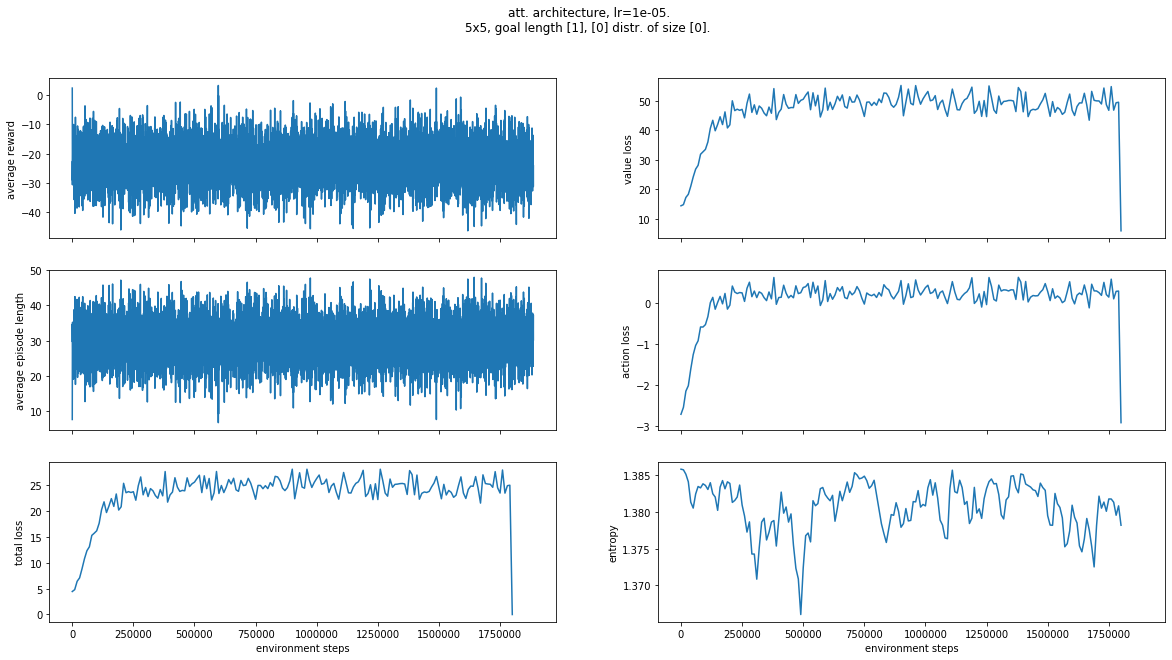

In [23]:
fig, axes = plt.subplots(3,2, sharex=True, figsize=(20,10))
for result in results: #iterate over seeds
    res_df = result.monitor
    res_df["cum_steps"] = results[0].monitor["l"].cumsum()
    res_df = res_df.groupby(np.arange(len(res_df))//10).mean()
    axes[0,0].plot(res_df.cum_steps, res_df.r)
    axes[0,0].set_ylabel("average reward")
    axes[1,0].plot(res_df.cum_steps, res_df.l)
    axes[1,0].set_ylabel("average episode length")
    
for i, measure in enumerate(["value loss", "action loss", "entropy"]):
    axes[i,1].plot(loss_xsteps, loss_df[measure])
    axes[i,1].set_ylabel(measure)
    
axes[2,0].plot(loss_xsteps, loss_df["action loss"] + 0.5*loss_df["value loss"] - 0.01*loss_df["entropy"])
axes[2,0].set_ylabel("total loss")

axes[2,0].set_xlabel("environment steps")
axes[2,1].set_xlabel("environment steps")

arch_id = "baseline" if config['net_config']['baseline_mode'] else "att."
plt.suptitle(
f"{arch_id} architecture, lr={config['lr']}.\n" \
f"{config['env_config']['n']}x{config['env_config']['n']}, " \
f"goal length {config['env_config']['list_goal_lengths']}, " \
f"{config['env_config']['list_num_distractors']} distr. " \
f"of size {config['env_config']['list_distractor_lengths']}. ")
fig.show()